N - L - R - V(PVC) - /(PB)      99.55     unbalance

Processing Records: 100%|██████████| 48/48 [00:05<00:00,  8.86it/s]


X shape: (109426, 400, 1)
y shape: (109426,)
Label classes: (array(['Fusion', 'Normal', 'SVEB', 'Unknown', 'VEB'], dtype='<U7'), array([  802, 90573,  2781,  8037,  7233], dtype=int64))


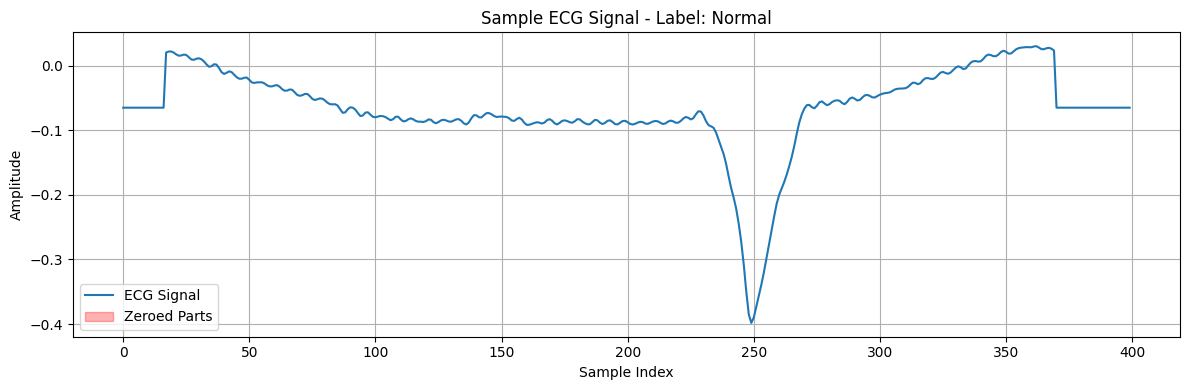

In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import butter, filtfilt

records = [
    "100", "101", "102", "103", "104", "105", "106", "107", "108", "109",
    "111", "112", "113", "114", "115", "116", "117", "118", "119",
    "121", "122", "123", "124",
    "200", "201", "202", "203", "205", "207", "208", "209", "210",
    "212", "213", "214", "215", "217", "219", "220", "221", "222", "223",
    "228", "230", "231", "232", "233", "234"
]

lowcut = 0.5  
highcut = 100  
window_size = 200  
after_size = 100  
extra_size = 50  

def bandpass_filter(signal, lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs  
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

aami_classes = {
    'Normal': ["N", "L", "R", "e", "j"],  
    'SVEB': ["A", "a", "J", "S"], 
    'VEB': ["V", "E"],  
    'Fusion': ["F"],  
    'Unknown': ["/", "f", "Q"]  
}

all_segments = []
all_labels = []

for record_name in tqdm(records, desc="Processing Records"):
    record = wfdb.rdrecord(record_name)
    annotation = wfdb.rdann(record_name, 'atr')
    signal = record.p_signal[:, 0]  
    sampling_rate = record.fs

    filtered_signal = bandpass_filter(signal, lowcut, highcut, sampling_rate)
    r_peaks = annotation.sample

    for r_peak in r_peaks:
        start = r_peak - (window_size + extra_size)
        end = r_peak + (after_size + extra_size)

        if start >= 0 and end < len(filtered_signal):
            segment = filtered_signal[start:end].copy()

            pre_zero_len = np.random.randint(0, extra_size + 1)
            post_zero_len = np.random.randint(0, extra_size + 1)

            segment[:pre_zero_len] = 0
            segment[-post_zero_len:] = 0

            label_idx = np.where(annotation.sample == r_peak)[0]
            if len(label_idx) > 0:
                label = annotation.symbol[label_idx[0]]
                all_segments.append(segment)
                all_labels.append(label)

mapped_segments = []
mapped_labels = []

for segment, label in zip(all_segments, all_labels):
    for aami_class, mit_labels in aami_classes.items():
        if label in mit_labels:
            mapped_segments.append(segment)
            mapped_labels.append(aami_class)
            break

X_filtered = np.array(mapped_segments)
X_filtered = (X_filtered - np.min(X_filtered)) / (np.max(X_filtered) - np.min(X_filtered))
X_filtered = 2 * X_filtered - 1

X = X_filtered[:, :, np.newaxis]
y = np.array(mapped_labels)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Label classes:", np.unique(y, return_counts=True))

sample_index = np.random.randint(len(X))
signal = X[sample_index, :, 0]
zero_mask = signal == 0

plt.figure(figsize=(12, 4))
plt.plot(signal, label='ECG Signal')
plt.fill_between(range(len(signal)), signal, where=zero_mask, color='red', alpha=0.3, label='Zeroed Parts')
plt.title(f"Sample ECG Signal - Label: {y[sample_index]}")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from collections import Counter

def undersample_majority_ir1(X, y, majority_label='Normal'):
    X = list(X)
    y = list(y)

    label_counts = Counter(y)
    print(f'Original label distribution: {label_counts}')

    minority_counts = [count for label, count in label_counts.items() if label != majority_label]
    max_minority_count = max(minority_counts)

    target_majority_count = 1 * max_minority_count
    print(f'Max minority count: {max_minority_count}')
    print(f'Target majority count (IR=3): {target_majority_count}')

    new_X = []
    new_y = []

    for label in label_counts:
        class_samples = [X[i] for i in range(len(y)) if y[i] == label]

        if label == majority_label:
            if len(class_samples) > target_majority_count:
                selected_indices = np.random.choice(len(class_samples), target_majority_count, replace=False)
                for idx in selected_indices:
                    new_X.append(class_samples[idx])
                    new_y.append(label)
                print(f'Undersampled "{label}" from {len(class_samples)} to {target_majority_count}')
            else:
                new_X.extend(class_samples)
                new_y.extend([label] * len(class_samples))
                print(f'No undersampling needed for "{label}", count = {len(class_samples)}')
        else:
            new_X.extend(class_samples)
            new_y.extend([label] * len(class_samples))

    final_counts = Counter(new_y)
    print(f'Final label distribution after undersampling: {final_counts}')
    print(f'Final IR (majority / max minority): {final_counts[majority_label] / max_minority_count:.2f}')

    return np.array(new_X), np.array(new_y)


balanced_X, balanced_y = undersample_majority_ir1(X, y, majority_label='Normal')

final_counts = Counter(balanced_y)
print(f'\nReduced dataset class counts: {final_counts}')


Original label distribution: Counter({'Normal': 90573, 'Unknown': 8037, 'VEB': 7233, 'SVEB': 2781, 'Fusion': 802})
Max minority count: 8037
Target majority count (IR=3): 8037
Undersampled "Normal" from 90573 to 8037
Final label distribution after undersampling: Counter({'Normal': 8037, 'Unknown': 8037, 'VEB': 7233, 'SVEB': 2781, 'Fusion': 802})
Final IR (majority / max minority): 1.00

Reduced dataset class counts: Counter({'Normal': 8037, 'Unknown': 8037, 'VEB': 7233, 'SVEB': 2781, 'Fusion': 802})


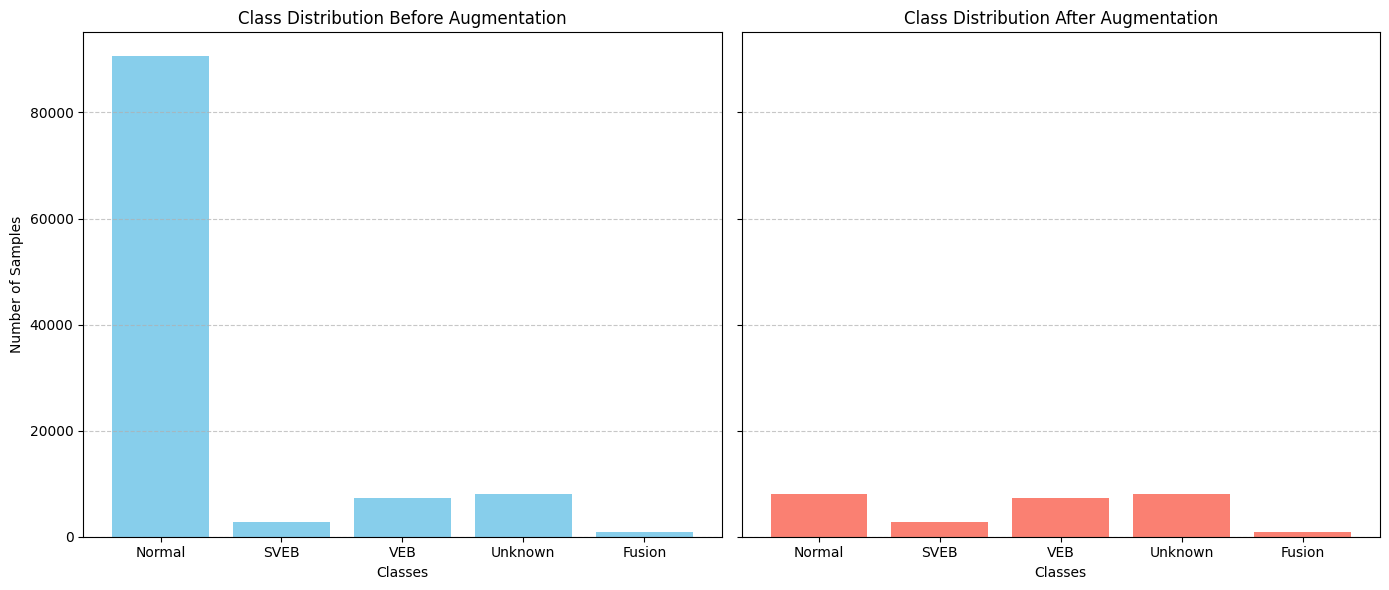

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

original_class_counts = Counter(y)

augmented_class_counts = Counter(balanced_y)

classes = list(original_class_counts.keys())
original_counts = [original_class_counts[cls] for cls in classes]
augmented_counts = [augmented_class_counts[cls] for cls in classes]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].bar(classes, original_counts, color='skyblue')
axes[0].set_title('Class Distribution Before Augmentation')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Number of Samples')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

axes[1].bar(classes, augmented_counts, color='salmon')
axes[1].set_title('Class Distribution After Augmentation')
axes[1].set_xlabel('Classes')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [21]:
balanced_X = balanced_X.reshape(-1, balanced_X.shape[1])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
balanced_X = scaler.fit_transform(balanced_X)  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau

X = np.expand_dims(balanced_X, axis=-1)

X_train, X_test, y_train2, y_test2 = train_test_split(X, balanced_y, test_size=0.2, random_state=42)

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train2)
y_test = encoder.transform(y_test2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

input_shape = X_train.shape[1:]
inputs = tf.keras.Input(shape=input_shape)

# --- Encoder ---
x = layers.Conv1D(128, 5, activation='relu', strides=2, padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv1D(64, 5, activation='relu', strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

encoded = x  

# --- Decoder ---
x = layers.Conv1DTranspose(64, 5, activation='relu', strides=2, padding='same')(encoded)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

decoded = layers.Conv1DTranspose(1, 5, activation='tanh', strides=2, padding='same')(x)

autoencoder = models.Model(inputs, decoded)
encoder_model = models.Model(inputs, encoded)

autoencoder.compile(optimizer='adam', loss='mse')

print("Training Autoencoder...")
autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, X_val),
    callbacks=[ReduceLROnPlateau(patience=5, factor=0.5)]
)

X_train_features = encoder_model.predict(X_train)
X_val_features = encoder_model.predict(X_val)
X_test_features = encoder_model.predict(X_test)





Training Autoencoder...
Epoch 1/50

269/269 [==============================] - 15s 45ms/step - loss: 0.0520 - val_loss: 0.0088 - lr: 0.0010
Epoch 2/50
269/269 [==============================] - 12s 45ms/step - loss: 0.0186 - val_loss: 0.0175 - lr: 0.0010
Epoch 3/50
269/269 [==============================] - 12s 46ms/step - loss: 0.0108 - val_loss: 0.0139 - lr: 0.0010
Epoch 4/50
269/269 [==============================] - 13s 48ms/step - loss: 0.0032 - val_loss: 6.0725e-04 - lr: 0.0010
Epoch 5/50
269/269 [==============================] - 13s 48ms/step - loss: 0.0030 - val_loss: 3.2577e-04 - lr: 0.0010
Epoch 6/50
269/269 [==============================] - 13s 47ms/step - loss: 0.0028 - val_loss: 5.1748e-04 - lr: 0.0010
Epoch 7/50
269/269 [==============================] - 13s 47ms/step - loss: 0.0027 - val_loss: 5.3252e-04 - lr: 0.0010
Epoch 8/50
269/269 [==============================] - 13s 47ms/step - loss: 0.0024 - val_loss: 9.3744e-04 - lr: 0.0010
Epoch 9/50
269/269 [============


Training Transformer...
Epoch 1/30

538/538 [==============================] - 163s 188ms/step - loss: 1.2140 - accuracy: 0.4893 - val_loss: 0.8165 - val_accuracy: 0.7195 - lr: 1.0000e-04
Epoch 2/30
538/538 [==============================] - 97s 181ms/step - loss: 0.6703 - accuracy: 0.7689 - val_loss: 0.4858 - val_accuracy: 0.8269 - lr: 1.0000e-04
Epoch 3/30
538/538 [==============================] - 94s 175ms/step - loss: 0.4635 - accuracy: 0.8379 - val_loss: 0.4025 - val_accuracy: 0.8613 - lr: 1.0000e-04
Epoch 4/30
538/538 [==============================] - 97s 181ms/step - loss: 0.3826 - accuracy: 0.8652 - val_loss: 0.3059 - val_accuracy: 0.8977 - lr: 1.0000e-04
Epoch 5/30
538/538 [==============================] - 95s 176ms/step - loss: 0.3174 - accuracy: 0.8894 - val_loss: 0.2514 - val_accuracy: 0.9156 - lr: 1.0000e-04
Epoch 6/30
538/538 [==============================] - 83s 154ms/step - loss: 0.2762 - accuracy: 0.9055 - val_loss: 0.2372 - val_accuracy: 0.9182 - lr: 1.0000e-04
E

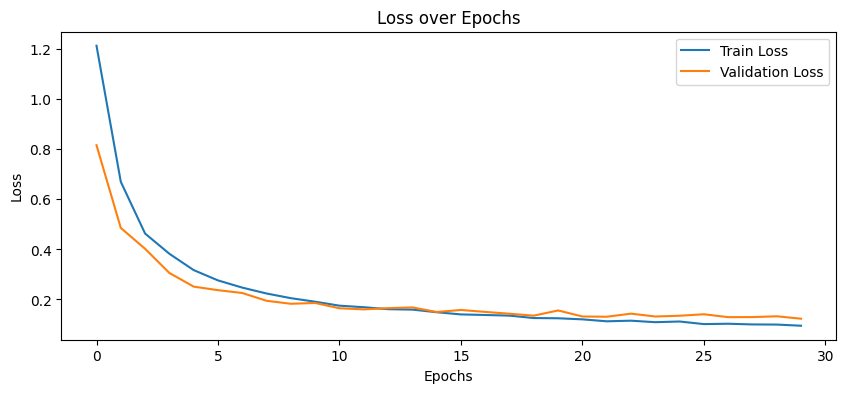

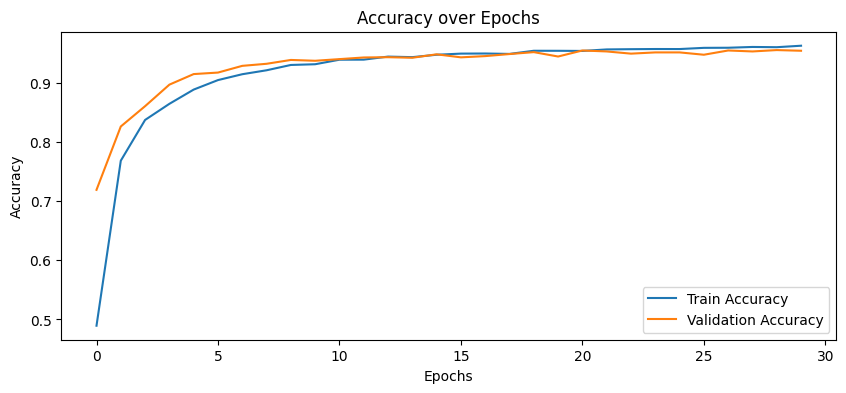

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Positional Encoding
class PositionalEncoding(layers.Layer):
    def __init__(self, maxlen, d_model):
        super().__init__()
        pos = np.arange(maxlen)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

# Transformer Encoder Block
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, num_heads, key_dim, ff_dim, dropout=0.1):
        super().__init__()
        self.input_dim = num_heads * key_dim
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.dropout1 = layers.Dropout(dropout)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)

        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(self.input_dim)
        ])
        self.dropout2 = layers.Dropout(dropout)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, x, training=False):
        attn_output = self.attention(x, x)
        attn_output = self.dropout1(attn_output, training=training)
        x = self.norm1(x + attn_output)

        ffn_output = self.ffn(x)
        ffn_output = self.dropout2(ffn_output, training=training)
        x = self.norm2(x + ffn_output)
        return x

seq_len = X_train_features.shape[1]
feature_dim = X_train_features.shape[2]

inputs = layers.Input(shape=(seq_len, feature_dim))
x = PositionalEncoding(seq_len, feature_dim)(inputs)

num_heads = 4
key_dim = feature_dim // num_heads
ff_dim = 256

for _ in range(2):
    skip = x
    x = TransformerEncoderBlock(num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim)(x)
    x = layers.Add()([x, skip])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

residual_dense = layers.GlobalAveragePooling1D()(x)

x = layers.Dense(512, activation='relu')(residual_dense)
x = layers.Dropout(0.2)(x)
x = layers.LayerNormalization()(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.LayerNormalization()(x)

x = layers.Dense(128, activation='relu')(x)

residual_mapped = layers.Dense(128)(residual_dense)
x = layers.Add()([x, residual_mapped])
x = layers.LayerNormalization()(x)

output = layers.Dense(len(np.unique(y_train)), activation='softmax')(x)

transformer_model = models.Model(inputs=inputs, outputs=output)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
transformer_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=6, verbose=1)

print("Training Transformer...")
history = transformer_model.fit(
    X_train_features, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val_features, y_val),
    callbacks=[lr_scheduler]
)

y_pred = transformer_model.predict(X_test_features)
y_pred_classes = np.argmax(y_pred, axis=1)

f1 = f1_score(y_test, y_pred_classes, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr', average='weighted')
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')

print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

test_loss, test_accuracy = transformer_model.evaluate(X_test_features, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()


<Figure size 1200x800 with 0 Axes>

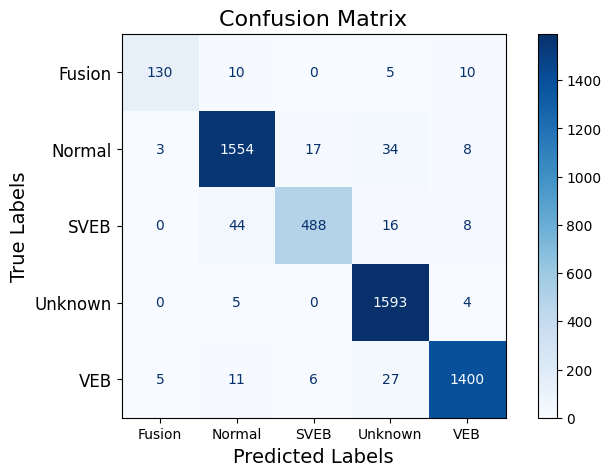

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_label_mapping = {
    'N': 'Normal',
    'L': 'LBBB',  # Left Bundle Branch Block
    'R': 'RBBB',  # Right Bundle Branch Block
    'V': 'PVC',   # Premature Ventricular Contraction
    '/': 'PB'     # Paced Beat
}

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(12, 8)) 
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[class_label_mapping.get(label, label) for label in encoder.classes_]
)
cm_display.plot(cmap=plt.cm.Blues, colorbar=True)  

plt.tick_params(axis='y', labelsize=12)  
plt.subplots_adjust(left=0.0, right=1, top=0.9, bottom=0.1)  

plt.title('Confusion Matrix', fontsize=16)  
plt.xlabel('Predicted Labels', fontsize=14)  
plt.ylabel('True Labels', fontsize=14)  

cm_output_path = "image/confusion_matrix_updatedir1aami.pdf"
plt.savefig(cm_output_path, format='pdf', dpi=300)
plt.show()  


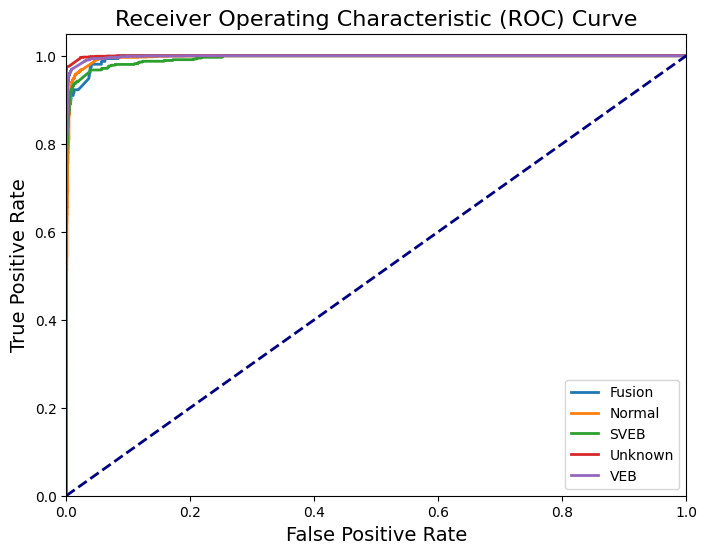

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

class_label_mapping = {
    'N': 'Normal beat',
    'L': 'Left bundle branch block beat',
    'R': 'Right bundle branch block beat',
    'V': 'Premature ventricular contraction',
    '/': 'Paced beat'
}

plt.figure(figsize=(8, 6))

for i in range(len(encoder.classes_)):
    y_test_binary = (y_test == i).astype(int)
    y_pred_class = y_pred[:, i]

    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_class)
    
    class_name = class_label_mapping.get(encoder.classes_[i], encoder.classes_[i])
    
    plt.plot(fpr, tpr, lw=2, label=f'{class_name}')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)

plt.legend(loc="lower right", fontsize=10)

roc_output_path = "image/roc_curve_no_auc.pdf"
plt.savefig(roc_output_path, format='pdf', dpi=300)
plt.show()
